In [27]:
'''
Kalyani Ramanan 19/06/2024
Speeding up Radtran.py script (from GHGSat) by isolating cross-section interpolation and writing interpolated files to.npy files
'''

'\nKalyani Ramanan 19/06/2024\nSpeeding up Radtran.py script (from GHGSat) by isolating cross-section interpolation and writing interpolated files to.npy files\n'

#### Import libraries, set up global variables, define key directory paths

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy import optimize
from scipy import interpolate
import os
import ee

import os

import ee
ee.Authenticate()

#Initialize earth engine for a new Python session

ee.Initialize(project = 'ee-krgeophys')

import geemap

from geemap import *

import numpy as np
import xarray as xr # May need to install using %pip install xarray
import datetime

from matplotlib import pyplot as plt

In [2]:
# Global variables
c = 299792458.
kB = 1.38064852e-23
deg = np.pi/180
mbartoatm = 0.000986923
kpatoatm = 0.00986923/1000.
kmtocm = 1E5
mtocm = 100.
mol=6.022140857E23
start_time = time.time()

# Key directories
aux_data_dir = 'aux_data'
hapi_data_dir = 'hapi_data'

### Find observing angle and solar zenith angle

In [3]:
# Define date and location of plume

source_lat = 31.6585
source_lon = 5.9053
print('Plume source at (', source_lat, ',',source_lon, ')')

# Define dates to filter image collection by (date of plume detection)

plume_date_start = '2019-11-20'
plume_date_end = '2019-11-21'
print('Plume detection date:' , plume_date_start)

# Define geometry as rectangle with coordinates at 2km distance from source (found using google maps)
lonmin = 5.88419
lonmax = 5.92609
latmin = 31.64011
latmax = 31.67640

# Define GEE geometry shape over this area
geometry_area = ee.Geometry.Rectangle([lonmin, latmin, lonmax, latmax], None, False)


Plume source at ( 31.6585 , 5.9053 )
Plume detection date: 2019-11-20


In [10]:
# Load TOA collection
collection = (
    ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
    .filterBounds(geometry_area) # Filter by geographical area using geometry rectangle defined above
    .filterDate(plume_date_start, plume_date_end) # Filter by date of plume detection
)

# Get image as first image for filtered collection
img = collection.first()

# Print image ID and spacecraft name
print('Image ID:', img.id().getInfo())
print('Spacecraft name:', img.get('SPACECRAFT_NAME').getInfo())

Image ID: 20191120T101321_20191120T101408_T31SGR
Spacecraft name: Sentinel-2A


In [11]:
img.get('MEAN_INCIDENCE_ZENITH_ANGLE_B11').getInfo()

9.93618296379

In [12]:
from datetime import datetime, timedelta

# Assuming plume_date_start is a string in 'YYYY-MM-DD' format
  # Example date
plume_date_start_dt = datetime.strptime(plume_date_start, '%Y-%m-%d')

# # Correct way to add 1 day to the date
next_day = plume_date_start_dt + timedelta(days=1)

# If you need to convert next_day back to a string
next_day_str = next_day.strftime('%Y-%m-%d')

print(next_day_str)



2019-11-21


In [14]:
from datetime import datetime

def find_angles(image_date, geometry_area):

    # get date of next day to filter image collection by
    image_date_dt = datetime.strptime(image_date, '%Y-%m-%d')
    # Correct way to add 1 day to the date
    next_day = image_date_dt + timedelta(days=1)

    # If you need to convert next_day back to a string
    next_day_str = next_day.strftime('%Y-%m-%d')
    print()


    # Load TOA collection
    collection = (
    ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
    .filterBounds(geometry_area) # Filter by geographical area using geometry rectangle defined above
    .filterDate(image_date, next_day_str) # Filter by date of plume detection
    )

    # Get image as first image for filtered collection


    img = collection.first()

    # Print image ID and spacecraft name
    print('Image ID:', img.id().getInfo())
    print('Spacecraft name:', img.get('SPACECRAFT_NAME').getInfo())

    obsangle = img.get('MEAN_INCIDENCE_ZENITH_ANGLE_B12').getInfo()
    solar_angle = img.get('MEAN_SOLAR_ZENITH_ANGLE').getInfo()
    print(f'Solar Zenith Angle: {solar_angle}')

    print(f'Observing Angle: {obsangle}')

    return solar_angle, obsangle





In [15]:
from datetime import datetime

plume_date_start = "2022-12-31"  # Replace with the actual value

# Convert plume_date_start to datetime format
plume_date_start_datetime = datetime.strptime(plume_date_start, "%Y-%m-%d")

# Print the datetime value
print(plume_date_start_datetime)

2022-12-31 00:00:00


In [17]:
geometry_area = ee.Geometry.Rectangle([lonmin, latmin, lonmax, latmax], None, False)
solarangle, obsangle = find_angles(plume_date_start, geometry_area)

EEException: GeometryConstructors.Rectangle, argument 'evenOdd': Invalid type.
Expected type: Boolean.
Actual type: String.
Actual value: EPSG:4326

### Import mixing ratios, temp, press profiles

In [36]:
def importMRTP(num_layers, targheight, obsheight, solarangle, obsangle, ch4_scale=1.1029, co2_scale=1.2424, h2o_scale=1):
    '''
    Load auxiliary data for vertical profiles of temperature, pressure, and CH4, CO2, and H2O mixing ratio.
    These data come from the U.S. Standard Atmosphere. 
    Also calculate the pathlength in each layer for input observation angles.
    CH4 and CO2 profiles need to be scaled up to match modern-day concentrations.

    Arguments
        num_layers [int]   : Number of vertical pressure layers for the radiative transfer calculation
        targheight [float] : Target elevation above sea level in km
        obsheight  [float] : Altitude of satellite instrument in km. Can use 100 km as if satellite were at top of atmosphere
        solarangle [float] : Solar zenith angle in degrees
        obsangle   [float] : Viewing zenith angle of instrument in degrees
        ch4_scale  [float] : Scale factor multiplying U.S. Standard CH4 profile (1.1029 implies 1875 ppb at the surface)
        co2_scale  [float] : Same but for U.S. Standard CO2 profile (1.2424 implies 410 ppm at the surface)
        h2o_scale  [float] : Same but for U.S. Standard H2O profile

    Returns
        pathlength [float] : Path length in each layer [cm]
        pressavg   [float] : Average pressure in each layer [atm]
        tempavg    [float] : Average temperature in each layer [K]
        mrCH4avg   [float] : Average CH4 mixing ratio in each layer
        mrCO2avg   [float] : Average CO2 mixing ratio in each layer
        mrH2Oavg   [float] : Average H2O mixing ratio in each layer
    ''' 
        
    # Mixing Ratio
    mrCH4 = np.transpose(np.genfromtxt(f'{aux_data_dir}/ch4.dat'))
    mrCO2 = np.transpose(np.genfromtxt(f'{aux_data_dir}/co2.dat'))
    mrH2O = np.transpose(np.genfromtxt(f'{aux_data_dir}/h2o.dat'))
    
    # Temperature
    temp = np.transpose(np.genfromtxt(f'{aux_data_dir}/temperature.dat'))
    
    # Pressure
    press = np.transpose(np.genfromtxt(f'{aux_data_dir}/pressure.dat'))
    
    # Define altitude in cm
    altitude = press[1][::-1] * kmtocm
    # Define pressure in atm
    pressure = press[0][::-1] * mbartoatm
    
    # Find pressure as a function of altitude
    altfine = np.arange(0, 10, 0.01)
    pressfine = np.interp(altfine, press[1], press[0]*mbartoatm)
    idfine = (np.abs(altfine-targheight)).argmin()
    pressmax = pressfine[idfine]    
    
    # Interpolate to get layers evenly spaced in pressure
    dpress = (pressmax-2.9608E-5)/num_layers
    pressinterp = np.arange(0, pressmax+dpress, dpress)
    altinterp = np.interp(pressinterp, pressure, altitude)

    # Find temperature at each altitude
    alttemp = temp[1]*kmtocm
    temperature = temp[0]
    tempinterp = np.interp(altinterp, alttemp, temperature)
    
    # Find mixing ratios at each altitude
    altmrCH4 = mrCH4[1]*kmtocm
    altmrCO2 = mrCO2[1]*kmtocm
    altmrH2O = mrH2O[1]*kmtocm
    mixrateCH4 = mrCH4[0]*ch4_scale
    mixrateCO2 = mrCO2[0]*co2_scale
    mixrateH2O = mrH2O[0]*h2o_scale
    
    # Interpolate and then sample using the altitude sample points determined from isobaric pressure increases
    mrCH4interp = np.interp(altinterp, altmrCH4, mixrateCH4)
    mrCO2interp = np.interp(altinterp, altmrCO2, mixrateCO2)
    mrH2Ointerp = np.interp(altinterp, altmrH2O, mixrateH2O)
    
    def find_nearest_alt(array,value):
        idx = (np.abs(array-value)).argmin()
        secondpass = array[idx:len(array)]
        zeroarray = np.zeros(idx)
        upwellingpass = np.concatenate((zeroarray, secondpass))
        return upwellingpass
    
    upwellingpass = find_nearest_alt(altinterp, obsheight*kmtocm)
    
    # Find path length of each layer
    pathlengthdown = np.zeros(num_layers)
    pathlengthup = np.zeros(num_layers)
    for i in range(0, num_layers):
        pathlengthdown[i] = np.absolute(altinterp[i]-altinterp[i+1])
        pathlengthup[i] = np.absolute(upwellingpass[i]-upwellingpass[i+1])
        
    # Calculate path given the Solar and observation angle from Nadir
    pathlength = pathlengthdown/np.cos(solarangle*deg) + pathlengthup/np.cos(obsangle*deg)
 
    # Define average value in layers
    pressavg = np.zeros(len(pathlength))
    tempavg = np.zeros(len(pathlength))
    mrCH4avg = np.zeros(len(pathlength))
    mrCO2avg = np.zeros(len(pathlength))
    mrH2Oavg = np.zeros(len(pathlength))   
    for i in range(0,len(pathlength)):
        pressavg[i] = (pressinterp[i+1]+pressinterp[i])/2.
        tempavg[i] = (tempinterp[i+1]+tempinterp[i])/2.
        mrCH4avg[i] = (mrCH4interp[i+1]+mrCH4interp[i])/2.
        mrCO2avg[i] = (mrCO2interp[i+1]+mrCO2interp[i])/2.
        mrH2Oavg[i] = (mrH2Ointerp[i+1]+mrH2Ointerp[i])/2.

    return pathlength, pressavg, tempavg, mrCH4avg, mrCO2avg, mrH2Oavg

### Save toasr, ods, solar spec for each band/instrument combo

In [37]:
# Configuration
num_layers = 100
targheight = 0
obsheight = 100
# solarangle = 40
# obsangle = 0
instrument = 'S2A'
method = 'MBSP'

In [38]:
# Import press, temp, pathlength and mixing ratios using ImportMRTP function
(L_cm, press_atm, temp, mrCH4, mrCO2, mrH2O) = importMRTP(num_layers, targheight, obsheight, solarangle, obsangle)
    


In [39]:
# Calculate and save optical densities

def save_optical_densities(instrument, band):

    # Load absorption cross-sections for S2A band 12

    wavelength = np.load(f'{hapi_data_dir}/abs_wave_hapi_{instrument}_band{band}.npy')
    press_load = np.load(f'{hapi_data_dir}/abs_press_hapi_{instrument}_band{band}.npy')
    temp_load = np.load(f'{hapi_data_dir}/abs_temp_hapi_{instrument}_band{band}.npy')   
    absCH4_load  = np.load(f'{hapi_data_dir}/abs_ch4_hapi_{instrument}_band{band}.npy')
    absCO2_load = np.load(f'{hapi_data_dir}/abs_co2_hapi_{instrument}_band{band}.npy')
    absH2O_load = np.load(f'{hapi_data_dir}/abs_h2o_hapi_{instrument}_band{band}.npy')
    num_wave = len(wavelength)

    # Calculate optical density
    odCH4pts_upper = np.zeros(num_wave)
    odCH4pts_lower = np.zeros(num_wave)
    odCO2pts = np.zeros(num_wave)
    odH2Opts = np.zeros(num_wave)


    interp_order = 3

    for i in range(num_wave):

        fCH4_tp = scipy.interpolate.RectBivariateSpline(temp_load, press_load, absCH4_load.T[i], kx=interp_order, ky=interp_order)
        fCO2_tp = scipy.interpolate.RectBivariateSpline(temp_load, press_load, absCO2_load.T[i], kx=interp_order, ky=interp_order)
        fH2O_tp = scipy.interpolate.RectBivariateSpline(temp_load, press_load, absH2O_load.T[i], kx=interp_order, ky=interp_order)
                # Get solar spectrum - also save since it changes for each band/instrument combo due to wavelength variable

        for j in range(num_layers):

            # Calculate density
            temperature_K = temp[j]
            pressure_atm = press_atm[j]
            pressure_Pa = pressure_atm*101325
            density_m3 = pressure_Pa/(kB*temperature_K)
            density_cm3 = density_m3/(1E6)

            # Evaluate interpolation function
            f_CH4_temp = fCH4_tp(temperature_K, pressure_atm)
            f_CO2_temp = fCO2_tp(temperature_K, pressure_atm)
            f_H2O_temp = fH2O_tp(temperature_K, pressure_atm)
                        
            # Calculate the (unit-less) optical density: OD = abs*n*MR*L
            lim_low = 6
            if j >= num_layers - lim_low:
                # Lowest 6 pressure layers = lowest 500 m of atmosphere (lower)
                odCH4pts_lower[i] = odCH4pts_lower[i] + f_CH4_temp*density_cm3*mrCH4[j]*L_cm[j]
            else:
                # The rest of the atmosphere (upper)
                odCH4pts_upper[i] = odCH4pts_upper[i] + f_CH4_temp*density_cm3*mrCH4[j]*L_cm[j]
            odCO2pts[i] = odCO2pts[i] + f_CO2_temp*density_cm3*mrCO2[j]*L_cm[j]
            odH2Opts[i] = odH2Opts[i] + f_H2O_temp*density_cm3*mrH2O[j]*L_cm[j]




    # Save optical densities
    
    # Create the directory if it doesn't exist
    directory = "optical_densities"
    if not os.path.exists(directory):
        os.makedirs(directory)

   # Save the variables to  .npy files
    np.save(os.path.join(directory, f"odCH4pts_upper_{instrument}_{band}.npy"), odCH4pts_upper)
    np.save(os.path.join(directory, f"odCH4pts_lower_{instrument}_{band}.npy"), odCH4pts_lower)
    np.save(os.path.join(directory, f"odH2Opts_{instrument}_{band}.npy"), odH2Opts)
    np.save(os.path.join(directory, f"odCO2pts_{instrument}_{band}.npy"), odCO2pts)


In [40]:
# Generate and save optical densities for S2A and S2B bands 11 and 12

instruments = ['S2A', 'S2B']
bands = ['11', '12']

# Don't run if files have already been saved
if not os.path.exists('optical_densities/odCH4pts_upper_S2A_12.npy'):
    
    for instrument in instruments:
        for band in bands:
            save_optical_densities(instrument, band)


In [41]:
# Generate solar spectrum for each instrument/band combo

def save_solar_spec(instrument, band):

    wavelength = np.load(f'{hapi_data_dir}/abs_wave_hapi_{instrument}_band{band}.npy')

    # Get solar spectrum - also save since it changes for each band/instrument combo due to wavelength variable
    solarspec = np.transpose(np.genfromtxt(f'{aux_data_dir}/SUNp01_4000_to_7000.txt'))
    wavesolar = 1E7/solarspec[0][::-1]
    radiancesolar = solarspec[1][::-1]*(100*solarspec[0][::-1]**2)
    solarradiance = np.interp(wavelength, wavesolar,radiancesolar)

    directory_solar = "solar_spectra"
    if not os.path.exists(directory_solar):
        os.makedirs(directory_solar)

    np.save(os.path.join(directory_solar, f"solar_spectrum_{instrument}_{band}.npy"), solarradiance)

In [42]:
# Generate and save optical densities for S2A and S2B bands 11 and 12

instruments = ['S2A', 'S2B']
bands = ['11', '12']

for instrument in instruments:
    for band in bands:
        save_solar_spec(instrument, band)
        print(f'{instrument} band {band} solar spectrum saved.')


S2A band 11 solar spectrum saved.
S2A band 12 solar spectrum saved.
S2B band 11 solar spectrum saved.
S2B band 12 solar spectrum saved.


In [43]:

def save_toasr(targheight, obsheight, solarangle, obsangle, instrument, band, num_layers=100):

    # Import press, temp, pathlength and mixing ratios using ImportMRTP function
    # Import pressure, temperature, path-length, and mixing ratios
    (L_cm, press_atm, temp, mrCH4, mrCO2, mrH2O) = importMRTP(num_layers, targheight, obsheight, solarangle, obsangle)

    # Calculate slant column density of methane
    cdCH4 = np.sum((press_atm/kpatoatm/(kB*temp)/mtocm**3)*mrCH4*L_cm/mol*mtocm**2)

    lim_low = 6
    
    press_atm_lower = press_atm[-lim_low:]
    temp_lower = temp[-lim_low:]
    L_cm_lower = L_cm[-lim_low:]
    cdCH4_lower = np.sum((press_atm_lower/kpatoatm/(kB*temp_lower)/mtocm**3)*mrCH4[-lim_low:]*L_cm_lower/mol*mtocm**2)

    # Load optical densities
    solarradiance = np.load(f'solar_spectra/solar_spectrum_{instrument}_{band}.npy')
    odCH4pts_lower = np.load(f'optical_densities/odCH4pts_lower_{instrument}_{band}.npy')
    odCO2pts = np.load(f'optical_densities/odCO2pts_{instrument}_{band}.npy')
    odCH4pts_upper = np.load(f'optical_densities/odCH4pts_upper_{instrument}_{band}.npy') 
    odH2Opts = np.load(f'optical_densities/odH2Opts_{instrument}_{band}.npy')     
    
    # Calculate the Top-Of-Atmosphere Spectral Radiance (TOASR) in the band [W/m2/m/sr]
    solar_spectrum = solarradiance/np.pi * np.cos(solarangle*deg)
    toasr = np.mean(np.exp(-(odCH4pts_lower + odCH4pts_upper + odCO2pts + odH2Opts)) * solar_spectrum)

    # save toasr 
    directory_toasr = "standard_toasr"
    if not os.path.exists(directory_toasr):
        os.makedirs(directory_toasr)

    np.save(os.path.join(directory_toasr, f"solar_spectrum_{instrument}_{band}.npy"), solarradiance)
    np.save(f'toasr_{instrument}_{band}.npy', toasr)





In [44]:
def save_toasr(targheight, obsheight, solarangle, obsangle, instrument, band, num_layers=100):

    # Import press, temp, pathlength and mixing ratios using ImportMRTP function
    # Import pressure, temperature, path-length, and mixing ratios
    (L_cm, press_atm, temp, mrCH4, mrCO2, mrH2O) = importMRTP(num_layers, targheight, obsheight, solarangle, obsangle)

    # Calculate slant column density of methane
    cdCH4 = np.sum((press_atm/kpatoatm/(kB*temp)/mtocm**3)*mrCH4*L_cm/mol*mtocm**2)

    lim_low = 6
    
    press_atm_lower = press_atm[-lim_low:]
    temp_lower = temp[-lim_low:]
    L_cm_lower = L_cm[-lim_low:]
    cdCH4_lower = np.sum((press_atm_lower/kpatoatm/(kB*temp_lower)/mtocm**3)*mrCH4[-lim_low:]*L_cm_lower/mol*mtocm**2)

    # Load optical densities
    solarradiance = np.load(f'solar_spectra/solar_spectrum_{instrument}_{band}.npy')
    odCH4pts_lower = np.load(f'optical_densities/odCH4pts_lower_{instrument}_{band}.npy')
    odCO2pts = np.load(f'optical_densities/odCO2pts_{instrument}_{band}.npy')
    odCH4pts_upper = np.load(f'optical_densities/odCH4pts_upper_{instrument}_{band}.npy') 
    odH2Opts = np.load(f'optical_densities/odH2Opts_{instrument}_{band}.npy')     
    
    # Calculate the Top-Of-Atmosphere Spectral Radiance (TOASR) in the band [W/m2/m/sr]
    solar_spectrum = solarradiance/np.pi * np.cos(solarangle*deg)
    toasr = np.mean(np.exp(-(odCH4pts_lower + odCH4pts_upper + odCO2pts + odH2Opts)) * solar_spectrum)

    # save toasr 
    directory_toasr = "standard_toasr"
    if not os.path.exists(directory_toasr):
        os.makedirs(directory_toasr)

    np.save(os.path.join(directory_toasr, f"solar_spectrum_{instrument}_{band}.npy"), solarradiance)
    np.save(f'toasr_{instrument}_{band}.npy', toasr)


In [45]:
# Generate and save optical densities for S2A and S2B bands 11 and 12

instruments = ['S2A', 'S2B']
bands = ['11', '12']

for instrument in instruments:
    for band in bands:
        save_toasr(targheight, obsheight, solarangle, obsangle, instrument, band, num_layers=100)
        print(f'toasr_{instrument} band {band} saved.')

toasr_S2A band 11 saved.
toasr_S2A band 12 saved.
toasr_S2B band 11 saved.
toasr_S2B band 12 saved.


#### Get obsangle and sza metadata for files

### Define radiative transfer equation

In [46]:
def radtran(targheight, obsheight, solarangle, obsangle, instrument, band, num_layers=100):

    # Import press, temp, pathlength and mixing ratios using ImportMRTP function
    # Import pressure, temperature, path-length, and mixing ratios
    (L_cm, press_atm, temp, mrCH4, mrCO2, mrH2O) = importMRTP(num_layers, targheight, obsheight, solarangle, obsangle)

    # Calculate slant column density of methane
    cdCH4 = np.sum((press_atm/kpatoatm/(kB*temp)/mtocm**3)*mrCH4*L_cm/mol*mtocm**2)

    lim_low = 6
    
    press_atm_lower = press_atm[-lim_low:]
    temp_lower = temp[-lim_low:]
    L_cm_lower = L_cm[-lim_low:]
    cdCH4_lower = np.sum((press_atm_lower/kpatoatm/(kB*temp_lower)/mtocm**3)*mrCH4[-lim_low:]*L_cm_lower/mol*mtocm**2)

    # Load optical densities
    solarradiance = np.load(f'solar_spectra/solar_spectrum_{instrument}_{band}.npy')
    odCH4pts_lower = np.load(f'optical_densities/odCH4pts_lower_{instrument}_{band}.npy')
    odCO2pts = np.load(f'optical_densities/odCO2pts_{instrument}_{band}.npy')
    odCH4pts_upper = np.load(f'optical_densities/odCH4pts_upper_{instrument}_{band}.npy') 
    odH2Opts = np.load(f'optical_densities/odH2Opts_{instrument}_{band}.npy')     
    
    # Calculate the Top-Of-Atmosphere Spectral Radiance (TOASR) in the band [W/m2/m/sr]
    solar_spectrum = solarradiance/np.pi * np.cos(solarangle*deg)
    toasr = np.mean(np.exp(-(odCH4pts_lower + odCH4pts_upper + odCO2pts + odH2Opts)) * solar_spectrum)

    # return toasr
    return toasr, odCH4pts_lower, odCH4pts_upper, odCO2pts, odH2Opts, solar_spectrum, cdCH4, cdCH4_lower



### Define retrieval function

In [47]:
def retrieve(frac_refl_data, instrument, method, targheight, obsheight, solarangle, obsangle, num_layers=100):
    '''
    Infer methane column enhancements from fractional reflectance measurements.

    Arguments
        frac_refl_data [float] : Array of fractional reflectance data, deltaR = (cR-R0)/R0
                                 e.g., DeltaR_SBMP from eq. (1) in Varon et al. 2021 AMT
        instrument     [str]   : MSI instrument. Choose 'S2A' or 'S2B'
        method         [str]   : Retrieval method corresponding to frac_refl_data
                                 Choose 'MBSP' or 'SBMP'
        targheight     [float] : Target elevation above sea level in km
        obsheight      [float] : Altitude of satellite instrument in km. Can use 100 km as if satellite were at top of atmosphere
        solarangle     [float] : Solar zenith angle in degrees
        obsangle       [float] : Viewing zenith angle of instrument in degrees
        num_layers     [int]   : Number of vertical pressure layers for the radiative transfer calculation
    '''

    # Get toasr, optical depths, etc. from radtran()
    toasr_11, odCH4_lower_11, odCH4_upper_11, odCO2_11, odH2O_11, solar_spectrum_11, _, _ = radtran(targheight, obsheight, solarangle, obsangle, instrument, band=11, num_layers=num_layers)
    toasr_12, odCH4_lower_12, odCH4_upper_12, odCO2_12, odH2O_12, solar_spectrum_12, cdCH4, cdCH4_lower = radtran(targheight, obsheight, solarangle, obsangle, instrument, band=12, num_layers=num_layers)
    
    def frac_abs_MBSP_difference(ch4_enh, data):
        '''
        Fractional absorption model to compare with measurements for MBSP method.
        
        Arguments
            ch4_enh [float] : Modeled enhancement as fraction of background
            data    [float] : Actual (cR-R0)/R0
        '''
            
        ch4 = ch4_enh + 1
        toasr_CH4enh_12 = np.mean(np.exp(-(ch4*odCH4_lower_12 + odCH4_upper_12 + odCO2_12 + odH2O_12))*solar_spectrum_12)
        toasr_CH4enh_11 = np.mean(np.exp(-(ch4*odCH4_lower_11 + odCH4_upper_11 + odCO2_11 + odH2O_11))*solar_spectrum_11)

        frac_abs_12 = (toasr_CH4enh_12 - toasr_12)/toasr_12
        frac_abs_11 = (toasr_CH4enh_11 - toasr_11)/toasr_11
        
        frac_abs_MBSP = frac_abs_12 - frac_abs_11 
            
        return frac_abs_MBSP - data


     
    start_time = time.time()

    # Do retrieval
    (num_rows, num_cols) = frac_refl_data.shape
    ch4_out = np.zeros((num_rows, num_cols))

    # add in counter
    count = 0

    for i in range(num_rows):
        for j in range(num_cols):

            data_temp = frac_refl_data[i,j]
                
            if np.isnan(data_temp):
                print('Found nan, skipping.')
                ch4_out[i,j] = np.nan
            
            # Solve for the best-fit fractional column (fraction of background)
            else:
                if method == 'SBMP':
                    ch4_temp = scipy.optimize.newton(lambda ch4_scale: frac_abs_SBMP_difference(ch4_scale,data_temp), 0, rtol=0.0001, maxiter=10000, disp=False)
                elif method == 'MBSP':
                    ch4_temp = scipy.optimize.newton(lambda ch4_scale: frac_abs_MBSP_difference(ch4_scale,data_temp), 0, rtol=0.0001, maxiter=10000, disp=False)
                    

                # Convert the fractional column to absolute vertical column density in mol/m2   
                AMF = 1/np.cos(obsangle*deg) + 1/np.cos(solarangle*deg)
                ch4_out[i,j] = ch4_temp * (cdCH4_lower/cdCH4)*(cdCH4/AMF)
                count = count + 1 
        
    # Time    
    print("--- %s seconds --- to optimize" % (time.time() - start_time))
    print(count)

    return ch4_out

In [48]:
import numpy as np
# Configuration
num_layers = 100
targheight = 0
solar_angle, obsangle = find_angles('2019-11-20', geometry_area)
instrument = 'S2A'
method = 'MBSP'

ch4_out = retrieve(np.array([[-0.2, -0.1, -0.22], [-0.22, -0.13, -0.2],[-0.12, -0.23, -0.22]]), instrument, method, targheight, obsheight, solarangle, obsangle, num_layers=100)
ch4_out


Image ID: 20191120T101321_20191120T101408_T31SGR
Spacecraft name: Sentinel-2A
Solar Zenith Angle: 53.6777266173
Observing Angle: 9.98701922366
--- 0.022118806838989258 seconds --- to optimize
9


array([[7.3085156 , 2.391813  , 8.91287461],
       [8.91287461, 3.48897085, 7.3085156 ],
       [3.09654288, 9.84539151, 8.91287461]])

### Generate scene using Hassi Messaoud plume



In [168]:
import os

import ee
ee.Authenticate()

#Initialize earth engine for a new Python session

ee.Initialize(project = 'ee-krgeophys')

import geemap

from geemap import *

import numpy as np
import xarray as xr # May need to install using %pip install xarray
import datetime

from matplotlib import pyplot as plt
# Define date and location of Hassi Messaoud plume

source_lat = 31.6585
source_lon = 5.9053
print('Plume source at (', source_lat, ',',source_lon, ')')

# Define dates to filter image collection by (date of plume detection)

plume_date_start = '2019-11-20'
plume_date_end = '2019-11-21'
print('Plume detection date:' , plume_date_start)

# Define geometry as rectangle with coordinates at 2km distance from source (found using google maps)
lonmin = 5.88419
lonmax = 5.92609
latmin = 31.64011
latmax = 31.67640

# Define GEE geometry shape over this area
geometry_area = ee.Geometry.Rectangle([lonmin, latmin, lonmax, latmax], None, False)

# solarangle, obsangle = find_angles(plume_date_start, geometry_area)
# Load TOA collection
collection = (
    ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
    .filterBounds(geometry_area) # Filter by geographical area using geometry rectangle defined above
    .filterDate(plume_date_start, plume_date_end) # Filter by date of plume detection
)

# Get image as first image for filtered collection
img = collection.first()

# Print image ID and spacecraft name
print('Image ID:', img.id().getInfo())
print('Spacecraft name:', img.get('SPACECRAFT_NAME').getInfo())
# Import image using above
img = ee.Image('COPERNICUS/S2_HARMONIZED/20191120T101321_20191120T101408_T31SGR')

# Create new image that is the concatenation of three images: a constant, the SWIR1 band and the SWIR2 band
B11 = img.select('B11').divide(10000)
B12 = img.select('B12').divide(10000)
imRegress = ee.Image.cat(B11, B12)

linearRegression = imRegress.reduceRegion(
    reducer = ee.Reducer.linearRegression(numX = 1, numY = 1),
    geometry = geometry_area,
    scale = 20,
)

c = linearRegression.get('coefficients').getInfo()[0]

#### Calculate MBSP

# Use image.expression() to write equation for R_MBSP
R_MBSP = img.expression(
    '(c*R12 - R11)/R11 ', # Where this number comes from least squares difference scale above
    {
        
        # 'c': linearRegression.get('coefficients').getInfo()[0],
        'c': c, 
        'R11': img.select('B11').divide(10000),
        'R12': img.select('B12').divide(10000),
    },
)

# Methane column enhancement in ppm
# F_MBSP = R_MBSP.subtract(-0.029)
F_MBSP = R_MBSP

F_MBSP_array = np.array(F_MBSP.sampleRectangle(geometry_area).get('constant').getInfo())


# Print image ID and spacecraft name
print('Image ID:', img.id().getInfo())
print('Spacecraft name:', img.get('SPACECRAFT_NAME').getInfo())

obsangle = img.get('MEAN_INCIDENCE_ZENITH_ANGLE_B12').getInfo()
solarangle = img.get('MEAN_SOLAR_ZENITH_ANGLE').getInfo()
print(f'Solar Zenith Angle: {solar_angle}')

print(f'Observing Angle: {obsangle}')
##### Plot transmittance map (fractional absorption)
# Get max and min R_MBSP values to compare with Fei's (min - -0.16 and max = -0.0150)
minval = F_MBSP.reduceRegion(ee.Reducer.min(), geometry = geometry_area).get('constant').getInfo()
maxval = F_MBSP.reduceRegion(ee.Reducer.max(), geometry = geometry_area).get('constant').getInfo()

print('min_val:',F_MBSP.reduceRegion(ee.Reducer.min(), geometry = geometry_area).get('constant').getInfo())
print('max_val:',F_MBSP.reduceRegion(ee.Reducer.max(), geometry = geometry_area).get('constant').getInfo())
# # Display F_MBSP on map

# Map = geemap.Map()

# # Define visualisation parameters for plot
# # vis = { 'min': -0.5, 'max': 0.05, "palette": ['FF0000',	'FFFFFF', '0000FF']}
# # vis = { 'min': -2, 'max': 2, "palette": ['FF0000',	'FFFFFF', '0000FF']}
# vis = { 'min': minval, 'max': maxval, "palette": ['FF0000',	'FFFFFF', '0000FF']}

# Map.setCenter(source_lon, source_lat, 13.75) # Define map centre
# Map.addLayer(F_MBSP, vis, 'Sentinel-2') # Add bands of Sentinel-2 data
# # Map.addLayer(geometry_area, {}, 'geometry_area') # Overlay rectangle used in Varon (2021) figure 2e
# Map.add_colorbar(vis, label='Methane enhancement ')
# Map

Plume source at ( 31.6585 , 5.9053 )
Plume detection date: 2019-11-20
Image ID: 20191120T101321_20191120T101408_T31SGR
Spacecraft name: Sentinel-2A
Image ID: 20191120T101321_20191120T101408_T31SGR
Spacecraft name: Sentinel-2A
Solar Zenith Angle: 40.0411640378
Observing Angle: 9.98701922366


#### Pass these values through retrieval code

In [122]:
ch4_enh = retrieve(F_MBSP_array, 'S2A', method, targheight, obsheight, solarangle, obsangle, num_layers=100)
ch4_enh

--- 43.005168437957764 seconds --- to optimize
42640


array([[7.76715625, 8.01078108, 7.76139973, ..., 7.72709873, 8.37645146,
        8.012066  ],
       [8.81186928, 8.33217099, 7.6245253 , ..., 9.11834027, 7.80896943,
        8.30182482],
       [8.35371915, 7.66781871, 8.53369011, ..., 9.68836871, 9.05489868,
        8.87440644],
       ...,
       [8.33341278, 8.8002041 , 9.37191412, ..., 8.11439352, 7.73700152,
        8.57886605],
       [8.39029423, 8.4628609 , 8.80326413, ..., 9.40785209, 9.98263202,
        8.25148802],
       [8.89055853, 8.48714063, 8.61463621, ..., 8.86510959, 7.29298085,
        6.98114684]])

In [123]:
minval = np.nanmin(ch4_enh)
maxval = np.nanmax(ch4_enh)
print(minval, maxval)

4.93372405135483 20.329214841819045


#### Plot conc enhancement map

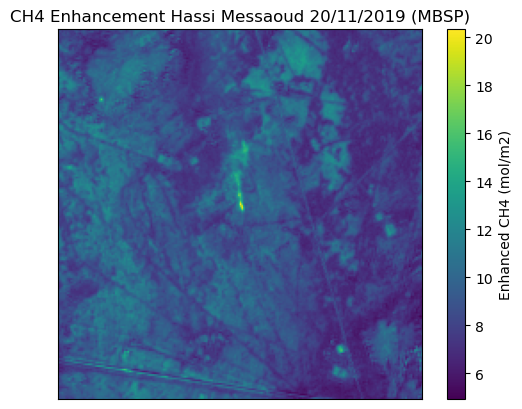

<Figure size 640x480 with 0 Axes>

In [178]:
import matplotlib.pyplot as plt

plt.imshow(ch4_enh, cmap='viridis')

plt.title('Enhanced CH4 2D Image Plot')
import matplotlib.pyplot as plt

# plt.imshow(ch4_enh, cmap='viridis',vmin =  -2, vmax= 2)
plt.imshow(ch4_enh, cmap='viridis')
# fig1 = plt.imshow(ch4_enh, cmap='viridis', vmin = minval, vmax = maxval)
plt.colorbar(label='Enhanced CH4 (mol/m2)')
plt.title('CH4 Enhancement Hassi Messaoud 20/11/2019 (MBSP)')
plt.xticks([])
plt.yticks([])
plt.show()
plt.savefig('varon_plume_test.png')

#### Calculate and plot MBMP image

##### get MBSP image for reference date

In [179]:
# Define date and location of Hassi Messaoud plume

source_lat = 31.6585
source_lon = 5.9053
print('Plume source at (', source_lat, ',',source_lon, ')')

# Define dates to filter image collection by (date of plume detection)

plume_date_start = '2019-10-06'
plume_date_end = '2019-10-07'
print('Plume detection date:' , plume_date_start)


#### Make a rectangle over area over which Varon 2021 images the Hassi Messaoud plume

# Define geometry as rectangle with coordinates at 2km distance from source (found using google maps)
lonmin = 5.88419
lonmax = 5.92609
latmin = 31.64011
latmax = 31.67640

# Set up GEE geometry shape
geometry_area = ee.Geometry.Rectangle([lonmin, latmin, lonmax, latmax], None, False)
# solarangle, obsangle = find_angles(, geometry_area) 
# Load TOA collection and get image name for reference day
plume_date_start = '2019-10-06'
plume_date_end = '2019-10-07'

collection = (
    ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
    .filterBounds(geometry_area) # Filter by geographical area using geometry rectangle defined above
    .filterDate(plume_date_start, plume_date_end) # Filter by date of plume detection
)

# Get image as first image for filtered collection
img = collection.first()

# Print image ID and spacecraft name
print('Image ID:', img.id().getInfo())

# Get angles and spacecraft name

# Print image ID and spacecraft name
print('Image ID:', img.id().getInfo())
print('Spacecraft name:', img.get('SPACECRAFT_NAME').getInfo())

obsangle = img.get('MEAN_INCIDENCE_ZENITH_ANGLE_B12').getInfo()
solarangle = img.get('MEAN_SOLAR_ZENITH_ANGLE').getInfo()
print(f'Solar Zenith Angle: {solar_angle}')

print(f'Observing Angle: {obsangle}')
# Import image using above
img = ee.Image('COPERNICUS/S2_HARMONIZED/'+img_ID)

# Create new image that is the concatenation of three images: a constant, the SWIR1 band and the SWIR2 band
B11 = img.select('B11').divide(10000)
B12 = img.select('B12').divide(10000)
imRegress = ee.Image.cat(B11, B12)

linearRegression = imRegress.reduceRegion(
    reducer = ee.Reducer.linearRegression(numX = 1, numY = 1),
    geometry = geometry_area,
    scale = 20,
)

c = linearRegression.get('coefficients').getInfo()[0]

# Use image.expression() to write equation for R_MBSP
R_MBSP_REF = img.expression(
    '(c*R12 - R11)/R11 ', # Where this number comes from least squares difference scale above
    {
        
        # 'c': linearRegression.get('coefficients').getInfo()[0],
        'c': c, 
        'R11': img.select('B11').divide(10000),
        'R12': img.select('B12').divide(10000),
    },
)

# Methane column enhancement in ppm for reference day
F_MBSP_REF = R_MBSP_REF
F_MBSP_REF_array = np.array(F_MBSP_REF.sampleRectangle(geometry_area).get('constant').getInfo())
# Get max and min R_MBSP values to compare with Fei's (min - -0.16 and max = -0.0150)
minval = F_MBSP_REF.reduceRegion(ee.Reducer.min(), geometry = geometry_area).get('constant').getInfo()
maxval = F_MBSP_REF.reduceRegion(ee.Reducer.max(), geometry = geometry_area).get('constant').getInfo()

print('min_val:',F_MBSP_REF.reduceRegion(ee.Reducer.min(), geometry = geometry_area).get('constant').getInfo())
print('max_val:',F_MBSP_REF.reduceRegion(ee.Reducer.max(), geometry = geometry_area).get('constant').getInfo())
# # Display F_MBSP on map

# Map = geemap.Map()

# # Define visualisation parameters for plot
# # vis = { 'min': -0.5, 'max': 0.05, "palette": ['FF0000',	'FFFFFF', '0000FF']}
# # vis = { 'min': -2, 'max': 2, "palette": ['FF0000',	'FFFFFF', '0000FF']}
# vis = { 'min': minval, 'max': maxval, "palette": ['FF0000',	'FFFFFF', '0000FF']}

# Map.setCenter(source_lon, source_lat, 13.75) # Define map centre
# Map.addLayer(F_MBSP_REF, vis, 'Sentinel-2') # Add bands of Sentinel-2 data
# # Map.addLayer(geometry_area, {}, 'geometry_area') # Overlay rectangle used in Varon (2021) figure 2e
# Map.add_colorbar(vis, label='Methane enhancement ')
# Map

Plume source at ( 31.6585 , 5.9053 )
Plume detection date: 2019-10-06
Image ID: 20191006T101029_20191006T101850_T31SGR
Image ID: 20191006T101029_20191006T101850_T31SGR
Spacecraft name: Sentinel-2B
Solar Zenith Angle: 40.0411640378
Observing Angle: 10.0363425987
min_val: -0.33443463428365205
max_val: -0.1895602727118411


In [180]:
instrument = 'S2B'

ch4_enh_REF = retrieve(F_MBSP_REF_array, instrument, method, targheight, obsheight, solarangle, obsangle, num_layers=100)
ch4_enh_REF

--- 105.80813241004944 seconds --- to optimize
42640


array([[20.11498177, 19.75677004, 21.6094879 , ..., 17.04500355,
        20.76989392, 18.11271225],
       [24.00698461, 21.74440377, 22.44553219, ..., 19.76989397,
        20.12133045, 20.20241238],
       [21.43397672, 21.20170659, 23.15952739, ..., 22.56712661,
        21.52951553, 21.93352766],
       ...,
       [23.76663904, 23.40827097, 25.72683136, ..., 23.43825148,
        23.9333416 , 26.9183791 ],
       [24.75213028, 24.31484572, 25.57756522, ..., 21.04005437,
        17.27935163, 24.31227875],
       [23.77167048, 25.84430422, 25.54867851, ..., 21.47469994,
        20.33212649, 21.6135283 ]])

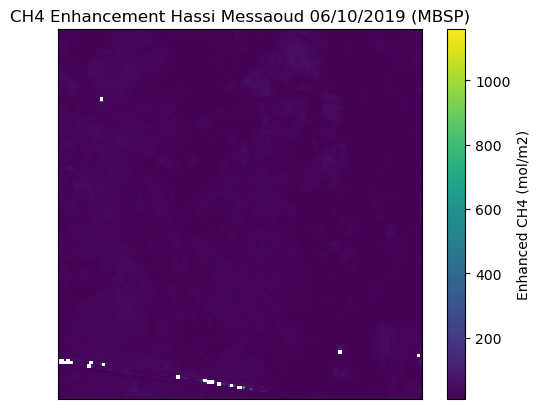

In [158]:
import matplotlib.pyplot as plt
plt.imshow(ch4_enh_REF, cmap='viridis')
plt.colorbar(label='Enhanced CH4 (mol/m2)')
plt.title('Enhanced CH4 2D Image Plot')
import matplotlib.pyplot as plt



plt.title('CH4 Enhancement Hassi Messaoud 06/10/2019 (MBSP)')
plt.xticks([])
plt.yticks([])
plt.show()
# plt.savefig('varon_plume_test.png')

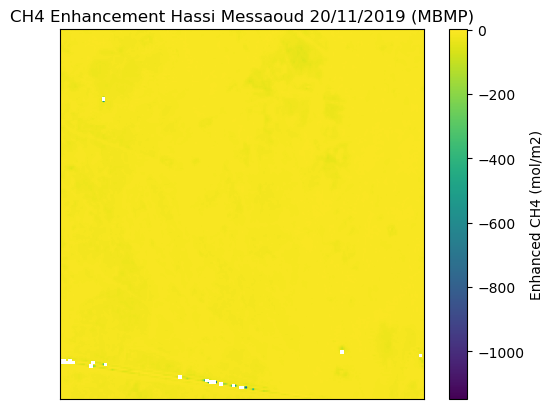

<Figure size 640x480 with 0 Axes>

In [160]:

import matplotlib.pyplot as plt
# plt.imshow(ch4_enh - ch4_enh_REF, cmap='viridis', vmin= -2, vmax=2 )
# plt.imshow(ch4_enh - ch4_enh_REF, cmap='viridis')

plt.imshow(np.subtract(ch4_enh, ch4_enh_REF), cmap='viridis')
plt.colorbar(label='Enhanced CH4 (mol/m2)')
plt.title('Enhanced CH4 2D Image Plot')
import matplotlib.pyplot as plt



plt.title('CH4 Enhancement Hassi Messaoud 20/11/2019 (MBMP)')
plt.xticks([])
plt.yticks([])
plt.show()
plt.savefig('varon_plume_test.png')

#### Calculate MBMP transmittance and pass that through for enhancement
Turns out this gives a different result, since it's using MBSP method in the retrieval code. Don't use this method.

In [182]:
# Frac MBMP
trans_MBMP = F_MBSP.subtract(F_MBSP_REF)

# transform to array
trans_MBMP_array = np.array(trans_MBMP.sampleRectangle(geometry_area).get('constant').getInfo())

In [183]:
# do retrieval

MBMP_enh = retrieve(trans_MBMP_array, 'S2A', method, targheight, obsheight, solarangle, obsangle, num_layers=100) 

--- 26.96992588043213 seconds --- to optimize
42640


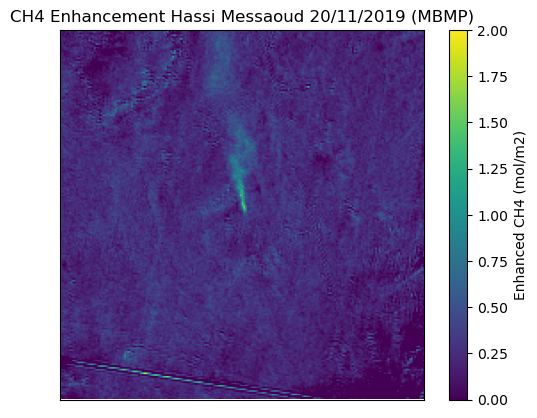

In [184]:
import matplotlib.pyplot as plt
plt.imshow(MBMP_enh, cmap='viridis', vmin= 0, vmax=2 ) 
plt.colorbar(label='Enhanced CH4 (mol/m2)')
plt.title('Enhanced CH4 2D Image Plot')
import matplotlib.pyplot as plt



plt.title('CH4 Enhancement Hassi Messaoud 20/11/2019 (MBMP)')
plt.xticks([])
plt.yticks([])
plt.show()


### Plot all 3 sped up radtran together

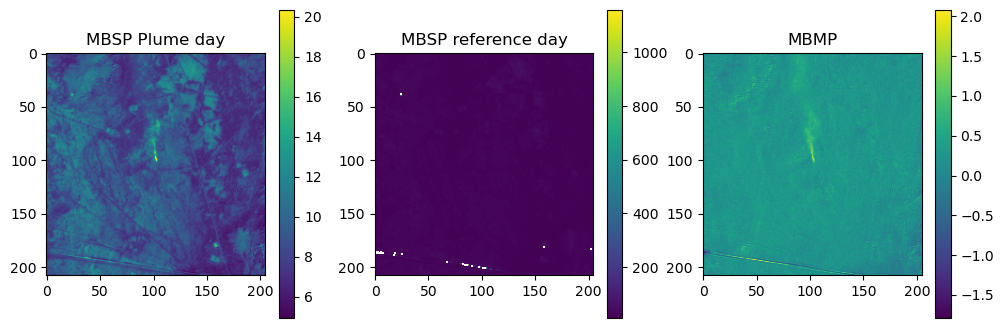

In [194]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(ch4_enh, cmap='viridis')
ax[0].set_title('MBSP Plume day')

# Adding colorbar to ax[0]
cbar = fig.colorbar(ax[0].images[0], ax=ax[0])
cbar.set_label('')

# MBSP REFERENCE DAY
ax[1].imshow(ch4_enh_REF, cmap='viridis')
ax[1].set_title('MBSP reference day')
cbar = fig.colorbar(ax[1].images[0], ax=ax[1])


# MBMP
ax[2].imshow(MBMP_enh, cmap='viridis')
ax[2].set_title('MBMP')
cbar = fig.colorbar(ax[2].images[0], ax=ax[2])



In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(ch4_enh, cmap='viridis', vmin = )
ax[0].set_title('MBSP Plume day')

# Adding colorbar to ax[0]
cbar = fig.colorbar(ax[0].images[0], ax=ax[0])
cbar.set_label('')

# MBSP REFERENCE DAY
ax[1].imshow(ch4_enh_REF, cmap='viridis')
ax[1].set_title('MBSP reference day')
cbar = fig.colorbar(ax[1].images[0], ax=ax[1])


# MBMP
ax[2].imshow(MBMP_enh, cmap='viridis')
ax[2].set_title('MBMP')
cbar = fig.colorbar(ax[2].images[0], ax=ax[2])


### Plot MBSP scene generated using original radtran

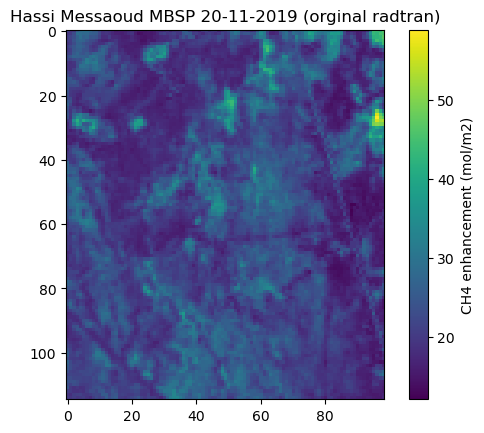

In [195]:
# To load data from the "TEST2.csv" file and plot it using `imshow`, you can use the following code:

# ```python
import numpy as np
import matplotlib.pyplot as plt

# Load data from CSV file
data = np.genfromtxt('TEST2_REF2.csv', delimiter=',')

# Plot data using imshow
plt.imshow(data, cmap='viridis')
c = plt.colorbar()

# Set the title
plt.title("Hassi Messaoud MBSP 20-11-2019 (orginal radtran)")

# Set the colorbar label
c.set_label("CH4 enhancement (mol/m2)")
plt.show()

# Make sure that the "TEST2.csv" file is in the same directory as your Jupyter Notebook. Adjust the `delimiter` parameter in the `np.genfromtxt` function if your CSV file has a different delimiter than a comma (`,`). Also, you can change the colormap (`cmap`) to any other available colormap of your choice.

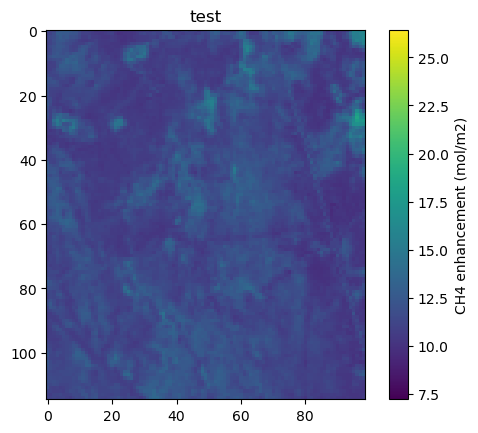

In [196]:
# To load data from the "TEST2.csv" file and plot it using `imshow`, you can use the following code:

# ```python
import numpy as np
import matplotlib.pyplot as plt

# Load data from CSV file
data2 = np.genfromtxt('TEST2_REF.csv', delimiter=',')

# Plot data using imshow
plt.imshow(data2, cmap='viridis')
c = plt.colorbar()
import matplotlib.pyplot as plt

# Your code here

# Set colorbar limit
cbar_min = 0
cbar_max = 100

# Plot the data
plt.imshow(data, cmap='viridis', vmin=cbar_min, vmax=cbar_max)
# plt.colorbar()
plt.title('test')

# Your code here


# Set the colorbar label
c.set_label("CH4 enhancement (mol/m2)")
plt.show()

In [68]:
data2.shape[1] * 20

1980

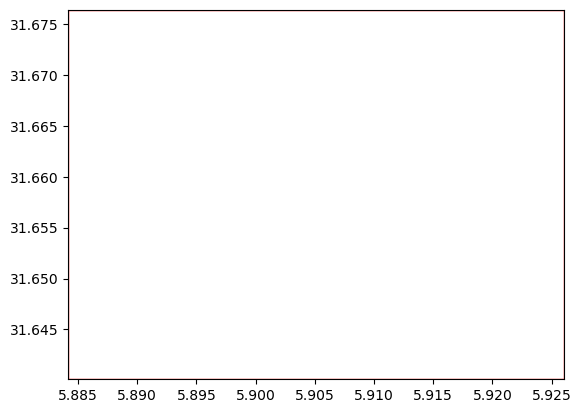

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define the coordinates
lonmin = 5.88419
lonmax = 5.92609
latmin = 31.64011
latmax = 31.67640

# Create a figure and axis
fig, ax = plt.subplots()

# Create a rectangle patch
rect = patches.Rectangle((lonmin, latmin), lonmax - lonmin, latmax - latmin, linewidth=1, edgecolor='r', facecolor='none')

# Add the rectangle patch to the axis
ax.add_patch(rect)

# Set the x and y axis limits
ax.set_xlim(lonmin, lonmax)
ax.set_ylim(latmin, latmax)

# Show the plot
plt.show()

#### source lat and lon 10km box

### Plot original radtran run 10km scenes of HM plume and reference day

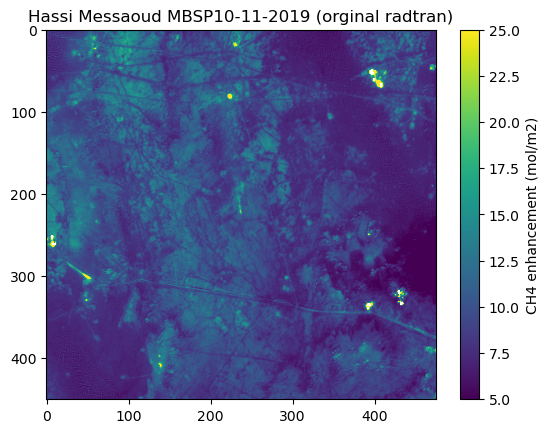

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Load data from CSV file
plume_day = np.genfromtxt('HM_PLUME_10K.csv', delimiter=',')

# Plot data using imshow
plt.imshow(plume_day, cmap='viridis', vmin = 5, vmax =25)
c = plt.colorbar()

# Set the title
plt.title("Hassi Messaoud MBSP10-11-2019 (orginal radtran)")

# Set the colorbar label
c.set_label("CH4 enhancement (mol/m2)")
plt.show()

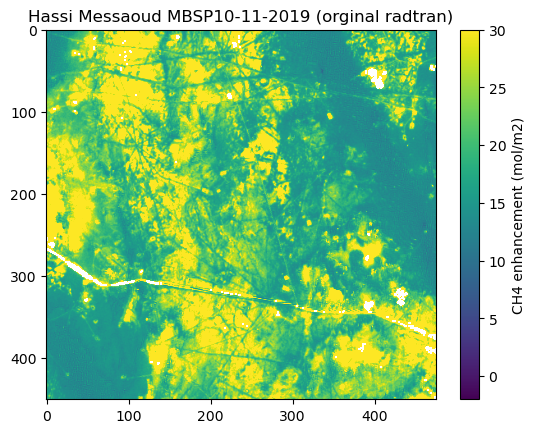

In [199]:
import numpy as np
import matplotlib.pyplot as plt

# Load data from CSV file
ref_day = np.genfromtxt('HM_PLUME_10K_refday.csv', delimiter=',')

# Plot data using imshow
plt.imshow(ref_day, cmap='viridis', vmin = -2, vmax =30)
c = plt.colorbar()

# Set the title
plt.title("Hassi Messaoud MBSP10-11-2019 (orginal radtran)")

# Set the colorbar label
c.set_label("CH4 enhancement (mol/m2)")
plt.show()

In [102]:
data2 - dataref

array([[  -5.37986955,   -5.66754153,   -3.67965975, ...,   -7.24563752,
          -7.7438682 ,   -6.61861659],
       [  -6.62074279,   -9.07235716,   -7.88258555, ...,   -6.75714332,
          -6.66703693,   -7.10914248],
       [  -6.65223428,   -7.24705132,   -5.73757246, ...,   -6.99235494,
          -6.24692874,   -7.18574917],
       ...,
       [  -6.27931511,   -8.53595623,   -6.93476037, ...,  -23.4710365 ,
                  nan,  -32.15519153],
       [  -6.11344081,   -9.35085159,   -6.52050463, ...,  -24.55524423,
                  nan,  -25.42069616],
       [  -6.78783281,   -9.81788762,   -7.77985909, ...,  -14.95694747,
        -190.15814581,  -17.21949708]])

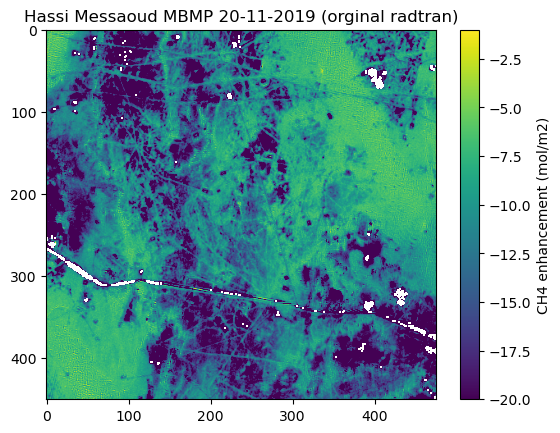

In [204]:
import numpy as np
import matplotlib.pyplot as plt

# Load data from CSV file
mbmp = plume_day - ref_day

# Plot data using imshow
plt.imshow(mbmp, cmap='viridis', vmin = -20, vmax =-1)
c = plt.colorbar()

# Set the title
plt.title("Hassi Messaoud MBMP 20-11-2019 (orginal radtran)")

# Set the colorbar label
c.set_label("CH4 enhancement (mol/m2)")
plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Load data from CSV file
mbmp = plume_day - ref_day

# Plot data using imshow
plt.imshow(mbmp, cmap='viridis', vmin = -20, vmax =0)
# plt.imshow(mbmp, cmap='viridis')
c = plt.colorbar()

# Set the title
plt.title("Hassi Messaoud MBMP 20-11-2019 (orginal radtran)")

# Set the colorbar label
c.set_label("CH4 enhancement (mol/m2)")
plt.show()

NameError: name 'plume_day' is not defined

### Plot 3 original radtran results

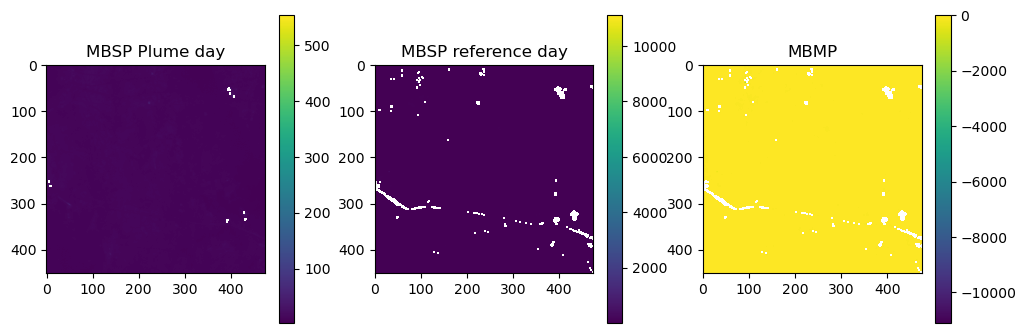

In [208]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(plume_day, cmap='viridis')
ax[0].set_title('MBSP Plume day')

# Adding colorbar to ax[0]
cbar = fig.colorbar(ax[0].images[0], ax=ax[0])
cbar.set_label('')

# MBSP REFERENCE DAY
ax[1].imshow(ref_day, cmap='viridis')
ax[1].set_title('MBSP reference day')
cbar = fig.colorbar(ax[1].images[0], ax=ax[1])


# MBMP
ax[2].imshow(mbmp, cmap='viridis')
ax[2].set_title('MBMP')
cbar = fig.colorbar(ax[2].images[0], ax=ax[2])



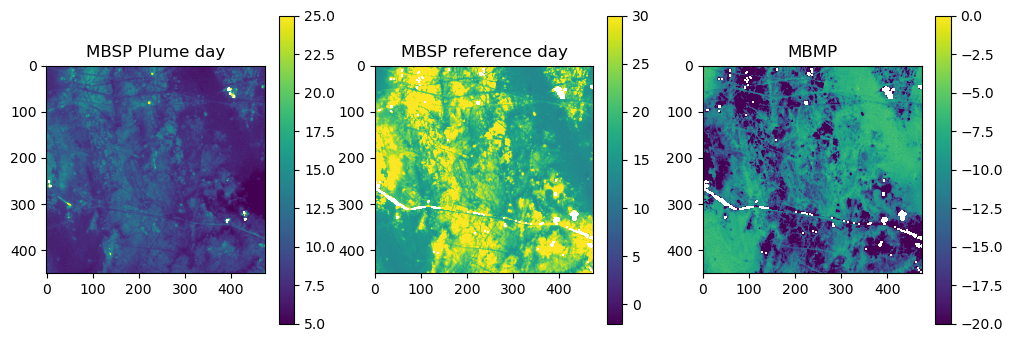

In [216]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(plume_day, cmap='viridis',  vmin = 5, vmax = 25)
ax[0].set_title('MBSP Plume day')

# Adding colorbar to ax[0]
cbar = fig.colorbar(ax[0].images[0], ax=ax[0])
cbar.set_label('')

# MBSP REFERENCE DAY
ax[1].imshow(ref_day, cmap='viridis', vmin = -2, vmax =30)
ax[1].set_title('MBSP reference day')
cbar = fig.colorbar(ax[1].images[0], ax=ax[1])


# MBMP
ax[2].imshow(mbmp, cmap='viridis', vmin = -20, vmax = 0)
ax[2].set_title('MBMP')
cbar = fig.colorbar(ax[2].images[0], ax=ax[2])

